In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Flatten, Input, concatenate
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score

from datetime import datetime
import cv2
import os
import zipfile
import shutil
from glob import glob
import glob

from tensorflow.keras.datasets import mnist
import tensorflow.keras.utils as utils


from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

from tensorflow.keras.applications import Xception, ResNet50, InceptionV3, MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator

> https://www.kaggle.com/datasets/paultimothymooney/blood-cells

In [2]:
##### Colab

ROOT_DIR = "/content"
DATA_ROOT_DIR = os.path.join(ROOT_DIR, "blood_cell")
TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "/content/blood_cell/TRAIN")
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "/content/blood_cell/TEST")
TEST_SIMPLE_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "/content/blood_cell/TEST_SIMPLE")

In [3]:
##### Colab
from google.colab import drive

drive.mount("/content/gdrive/")

shutil.copy(os.path.join("/content/gdrive/MyDrive/acorn", "blood_cell.zip"), ROOT_DIR)

if os.path.exists(DATA_ROOT_DIR):
    shutil.rmtree(DATA_ROOT_DIR)

with zipfile.ZipFile(os.path.join(ROOT_DIR, "blood_cell.zip"), "r") as target_file:
    target_file.extractall(DATA_ROOT_DIR)

Mounted at /content/gdrive/


In [4]:
##### remove blood_cell in blood_cell
source_dir = '/content/blood_cell/blood_cell'
target_dir = '/content/blood_cell'

# Get a list of directories in the source directory
directories = next(os.walk(source_dir))[1]

# Move each directory to the target directory
for directory in directories:
    source_path = os.path.join(source_dir, directory)
    target_path = os.path.join(target_dir, directory)
    shutil.move(source_path, target_path)

directory_to_remove = '/content/blood_cell/blood_cell'

# Remove the directory and its contents
shutil.rmtree(directory_to_remove)

In [5]:

train_label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print(train_label_name_list)

for label_name in train_label_name_list:
    print("test label :", label_name, " => ", len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))


test_label_name_list = os.listdir(TEST_DATA_ROOT_DIR)
print(test_label_name_list)

for label_name in test_label_name_list:
    print("test label :", label_name, " => ", len(os.listdir(os.path.join(TEST_DATA_ROOT_DIR, label_name))))


test_simple_label_name_list = os.listdir(TEST_SIMPLE_DATA_ROOT_DIR)
print(test_simple_label_name_list)

for label_name in test_simple_label_name_list:
    print("val label :", label_name, " => ", len(os.listdir(os.path.join(TEST_SIMPLE_DATA_ROOT_DIR, label_name))))

['NEUTROPHIL', 'MONOCYTE', 'EOSINOPHIL', 'LYMPHOCYTE']
test label : NEUTROPHIL  =>  2499
test label : MONOCYTE  =>  2478
test label : EOSINOPHIL  =>  2497
test label : LYMPHOCYTE  =>  2483
['NEUTROPHIL', 'MONOCYTE', 'EOSINOPHIL', 'LYMPHOCYTE']
test label : NEUTROPHIL  =>  624
test label : MONOCYTE  =>  620
test label : EOSINOPHIL  =>  623
test label : LYMPHOCYTE  =>  620
['NEUTROPHIL', 'MONOCYTE', 'EOSINOPHIL', 'LYMPHOCYTE']
val label : NEUTROPHIL  =>  48
val label : MONOCYTE  =>  4
val label : EOSINOPHIL  =>  13
val label : LYMPHOCYTE  =>  6


In [6]:
##### Let's shuffle

test_label_name_list = os.listdir(TEST_DATA_ROOT_DIR)
print(test_label_name_list)

['NEUTROPHIL', 'MONOCYTE', 'EOSINOPHIL', 'LYMPHOCYTE']


In [7]:
##### Move to TRAIN at all files in TEST
for label_name in test_label_name_list:
    test_path = os.path.join(TEST_DATA_ROOT_DIR, label_name)
    test_file_list = os.listdir(test_path)

    train_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)

    move_num = 0

    for test_file in test_file_list:
        shutil.move(os.path.join(test_path, test_file),
                   os.path.join(train_path, test_file))
        move_num = move_num + 1

    print(str(move_num) + " is moved into " + label_name + \
         "(TEST => Train)")

624 is moved into NEUTROPHIL(TEST => Train)
620 is moved into MONOCYTE(TEST => Train)
623 is moved into EOSINOPHIL(TEST => Train)
620 is moved into LYMPHOCYTE(TEST => Train)


In [8]:
##### Move to TRAIN all files in TEST_SIMPLE
for label_name in test_simple_label_name_list:
    test_simple_path = os.path.join(TEST_SIMPLE_DATA_ROOT_DIR, label_name)
    test_simple_file_list = os.listdir(test_simple_path)

    train_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)

    move_num = 0

    for test_simple_file in test_simple_file_list:
        shutil.move(os.path.join(test_simple_path, test_simple_file),
                   os.path.join(train_path, test_simple_file))
        move_num = move_num + 1

    print(str(move_num) + " is moved into " + label_name + \
         "(TEST_SIMPLE => Train)")

48 is moved into NEUTROPHIL(TEST_SIMPLE => Train)
4 is moved into MONOCYTE(TEST_SIMPLE => Train)
13 is moved into EOSINOPHIL(TEST_SIMPLE => Train)
6 is moved into LYMPHOCYTE(TEST_SIMPLE => Train)


In [9]:

train_label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print(train_label_name_list)

for label_name in train_label_name_list:
    print("test label :", label_name, " => ", len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))

['NEUTROPHIL', 'MONOCYTE', 'EOSINOPHIL', 'LYMPHOCYTE']
test label : NEUTROPHIL  =>  3171
test label : MONOCYTE  =>  3095
test label : EOSINOPHIL  =>  3133
test label : LYMPHOCYTE  =>  3108


In [10]:

MOVE_RATIO = 0.2

label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)

for label_name in label_name_list:
    src = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
    dst = os.path.join(TEST_DATA_ROOT_DIR, label_name)

    train_data_file_list = os.listdir(src)

    print("============================================")
    print("total [%s] data file nums => [%s]"%(label_name, len(train_data_file_list)))

    np.random.shuffle(train_data_file_list)
    print("train data shuffle is done!")

    split_num = int(MOVE_RATIO * len(train_data_file_list))
    print("split num => ", split_num)

    test_data_file_list = train_data_file_list[0:split_num]

    move_num = 0
    for test_data_file in test_data_file_list:
        shutil.move(os.path.join(src, test_data_file),
                   os.path.join(dst, test_data_file))
        move_num = move_num + 1

    print("total move num => ", move_num)
    print("=============================================")

total [NEUTROPHIL] data file nums => [3171]
train data shuffle is done!
split num =>  634
total move num =>  634
total [MONOCYTE] data file nums => [3095]
train data shuffle is done!
split num =>  619
total move num =>  619
total [EOSINOPHIL] data file nums => [3133]
train data shuffle is done!
split num =>  626
total move num =>  626
total [LYMPHOCYTE] data file nums => [3108]
train data shuffle is done!
split num =>  621
total move num =>  621


In [11]:

train_label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print(train_label_name_list)

for label_name in train_label_name_list:
    print("test label :", label_name, " => ", len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))

test_label_name_list = os.listdir(TEST_DATA_ROOT_DIR)
print(test_label_name_list)

for label_name in test_label_name_list:
    print("test label :", label_name, " => ", len(os.listdir(os.path.join(TEST_DATA_ROOT_DIR, label_name))))

['NEUTROPHIL', 'MONOCYTE', 'EOSINOPHIL', 'LYMPHOCYTE']
test label : NEUTROPHIL  =>  2537
test label : MONOCYTE  =>  2476
test label : EOSINOPHIL  =>  2507
test label : LYMPHOCYTE  =>  2487
['NEUTROPHIL', 'MONOCYTE', 'EOSINOPHIL', 'LYMPHOCYTE']
test label : NEUTROPHIL  =>  634
test label : MONOCYTE  =>  619
test label : EOSINOPHIL  =>  626
test label : LYMPHOCYTE  =>  621


Found 8007 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.
Found 2500 images belonging to 4 classes.
Found 0 images belonging to 4 classes.
{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}
4
(16, 224, 224, 3) (16,)
[1. 2. 2. 0. 3. 0. 2. 3. 2. 1. 3. 0. 0. 1. 0. 0.]
17225924/17225924 [==============================] - 2s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv

251/251 [==============================] - 60s 141ms/step - loss: 1.8865 - acc: 0.2579 - val_loss: 1.3377 - val_acc: 0.3590
Epoch 2/20
251/251 [==============================] - ETA: 0s - loss: 1.5605 - acc: 0.2789
Epoch 2: val_loss improved from 1.33768 to 1.31048, saving model to content/


251/251 [==============================] - 33s 133ms/step - loss: 1.5605 - acc: 0.2789 - val_loss: 1.3105 - val_acc: 0.4130
Epoch 3/20
251/251 [==============================] - ETA: 0s - loss: 1.4632 - acc: 0.2960
Epoch 3: val_loss improved from 1.31048 to 1.29511, saving model to content/


251/251 [==============================] - 34s 134ms/step - loss: 1.4632 - acc: 0.2960 - val_loss: 1.2951 - val_acc: 0.4610
Epoch 4/20
251/251 [==============================] - ETA: 0s - loss: 1.3991 - acc: 0.3196
Epoch 4: val_loss improved from 1.29511 to 1.27308, saving model to content/


251/251 [==============================] - 34s 134ms/step - loss: 1.3991 - acc: 0.3196 - val_loss: 1.2731 - val_acc: 0.5170
Epoch 5/20
251/251 [==============================] - ETA: 0s - loss: 1.3663 - acc: 0.3411
Epoch 5: val_loss improved from 1.27308 to 1.24414, saving model to content/


251/251 [==============================] - 33s 133ms/step - loss: 1.3663 - acc: 0.3411 - val_loss: 1.2441 - val_acc: 0.5810
Epoch 6/20
251/251 [==============================] - ETA: 0s - loss: 1.3062 - acc: 0.3740
Epoch 6: val_loss improved from 1.24414 to 1.18867, saving model to content/


251/251 [==============================] - 34s 136ms/step - loss: 1.3062 - acc: 0.3740 - val_loss: 1.1887 - val_acc: 0.6280
Epoch 7/20
251/251 [==============================] - ETA: 0s - loss: 1.2679 - acc: 0.4130
Epoch 7: val_loss improved from 1.18867 to 1.11409, saving model to content/


251/251 [==============================] - 34s 134ms/step - loss: 1.2679 - acc: 0.4130 - val_loss: 1.1141 - val_acc: 0.6770
Epoch 8/20
251/251 [==============================] - ETA: 0s - loss: 1.2029 - acc: 0.4501
Epoch 8: val_loss improved from 1.11409 to 1.00598, saving model to content/


251/251 [==============================] - 34s 136ms/step - loss: 1.2029 - acc: 0.4501 - val_loss: 1.0060 - val_acc: 0.6995
Epoch 9/20
251/251 [==============================] - ETA: 0s - loss: 1.1269 - acc: 0.4958
Epoch 9: val_loss improved from 1.00598 to 0.87581, saving model to content/


251/251 [==============================] - 34s 134ms/step - loss: 1.1269 - acc: 0.4958 - val_loss: 0.8758 - val_acc: 0.7305
Epoch 10/20
251/251 [==============================] - ETA: 0s - loss: 1.0302 - acc: 0.5449
Epoch 10: val_loss improved from 0.87581 to 0.73913, saving model to content/


251/251 [==============================] - 34s 134ms/step - loss: 1.0302 - acc: 0.5449 - val_loss: 0.7391 - val_acc: 0.7550
Epoch 11/20
251/251 [==============================] - ETA: 0s - loss: 0.9251 - acc: 0.5980
Epoch 11: val_loss improved from 0.73913 to 0.62076, saving model to content/


251/251 [==============================] - 34s 136ms/step - loss: 0.9251 - acc: 0.5980 - val_loss: 0.6208 - val_acc: 0.7925
Epoch 12/20
251/251 [==============================] - ETA: 0s - loss: 0.8359 - acc: 0.6413
Epoch 12: val_loss improved from 0.62076 to 0.53102, saving model to content/


251/251 [==============================] - 34s 135ms/step - loss: 0.8359 - acc: 0.6413 - val_loss: 0.5310 - val_acc: 0.8210
Epoch 13/20
251/251 [==============================] - ETA: 0s - loss: 0.7398 - acc: 0.6916
Epoch 13: val_loss improved from 0.53102 to 0.45919, saving model to content/


251/251 [==============================] - 34s 134ms/step - loss: 0.7398 - acc: 0.6916 - val_loss: 0.4592 - val_acc: 0.8560
Epoch 14/20
251/251 [==============================] - ETA: 0s - loss: 0.6621 - acc: 0.7251
Epoch 14: val_loss improved from 0.45919 to 0.38949, saving model to content/


251/251 [==============================] - 34s 135ms/step - loss: 0.6621 - acc: 0.7251 - val_loss: 0.3895 - val_acc: 0.8950
Epoch 15/20
251/251 [==============================] - ETA: 0s - loss: 0.6014 - acc: 0.7532
Epoch 15: val_loss improved from 0.38949 to 0.33185, saving model to content/


251/251 [==============================] - 33s 133ms/step - loss: 0.6014 - acc: 0.7532 - val_loss: 0.3319 - val_acc: 0.9090
Epoch 16/20
251/251 [==============================] - ETA: 0s - loss: 0.5250 - acc: 0.7916
Epoch 16: val_loss improved from 0.33185 to 0.28059, saving model to content/


251/251 [==============================] - 34s 135ms/step - loss: 0.5250 - acc: 0.7916 - val_loss: 0.2806 - val_acc: 0.9195
Epoch 17/20
251/251 [==============================] - ETA: 0s - loss: 0.4803 - acc: 0.8065
Epoch 17: val_loss improved from 0.28059 to 0.23651, saving model to content/


251/251 [==============================] - 34s 134ms/step - loss: 0.4803 - acc: 0.8065 - val_loss: 0.2365 - val_acc: 0.9315
Epoch 18/20
251/251 [==============================] - ETA: 0s - loss: 0.4194 - acc: 0.8379
Epoch 18: val_loss improved from 0.23651 to 0.20622, saving model to content/


251/251 [==============================] - 33s 133ms/step - loss: 0.4194 - acc: 0.8379 - val_loss: 0.2062 - val_acc: 0.9370
Epoch 19/20
251/251 [==============================] - ETA: 0s - loss: 0.3658 - acc: 0.8604
Epoch 19: val_loss improved from 0.20622 to 0.17249, saving model to content/


251/251 [==============================] - 33s 133ms/step - loss: 0.3658 - acc: 0.8604 - val_loss: 0.1725 - val_acc: 0.9450
Epoch 20/20
251/251 [==============================] - ETA: 0s - loss: 0.3288 - acc: 0.8717
Epoch 20: val_loss improved from 0.17249 to 0.14994, saving model to content/


251/251 [==============================] - 33s 133ms/step - loss: 0.3288 - acc: 0.8717 - val_loss: 0.1499 - val_acc: 0.9515
Elapsed Time :  0:11:40.718557


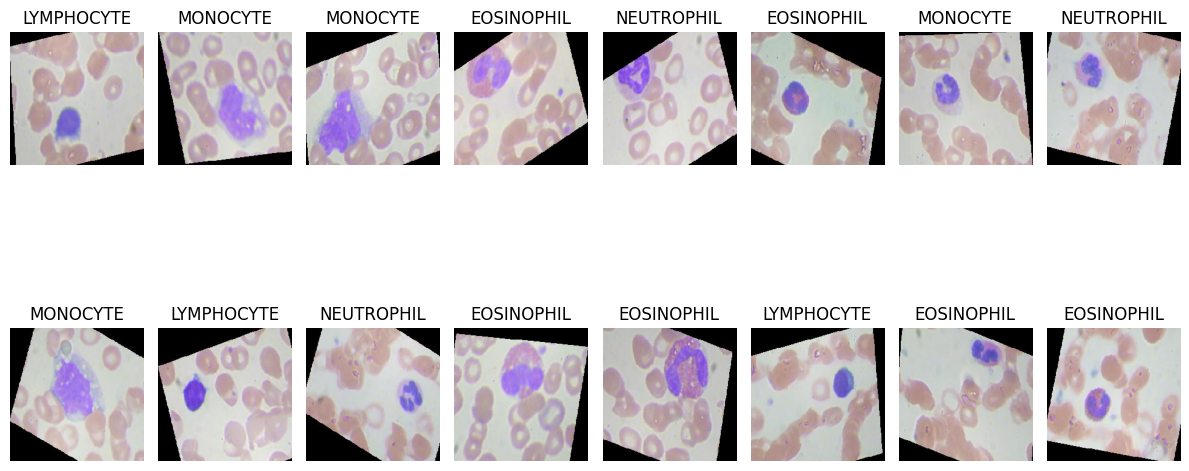

In [12]:
IMG_WIDTH = 224
IMG_HEIGHT = 224


train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)
test_simple_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(directory=TRAIN_DATA_ROOT_DIR, batch_size=32, color_mode='rgb'
                        ,target_size=(IMG_WIDTH, IMG_HEIGHT),
                       class_mode = "sparse", subset="training")

val_generator = validation_datagen.flow_from_directory(directory=TRAIN_DATA_ROOT_DIR, batch_size=32, color_mode='rgb'
                        ,target_size=(IMG_WIDTH, IMG_HEIGHT),
                       class_mode = "sparse", subset="validation")

test_generator = test_datagen.flow_from_directory(directory=TEST_DATA_ROOT_DIR, batch_size=32, color_mode='rgb'
                        ,target_size=(IMG_WIDTH, IMG_HEIGHT),
                       class_mode = "sparse")
test_simple_generator = test_datagen.flow_from_directory(directory=TEST_SIMPLE_DATA_ROOT_DIR, batch_size=32, color_mode='rgb'
                        ,target_size=(IMG_WIDTH, IMG_HEIGHT),
                       class_mode = "sparse")

print(train_generator.class_indices)
print(train_generator.num_classes)

data, label = train_generator.next()

data = data[:16]
label = label[:16]

print(data.shape, label.shape)
print(label)

plt.figure(figsize=(12, 12))
class_dict = {0 : 'EOSINOPHIL', 1 : 'LYMPHOCYTE', 2 : 'MONOCYTE', 3 : 'NEUTROPHIL'}


for i in range(len(label)):
    plt.subplot(4, 8, i+1)
    plt.axis("off")
    plt.title(class_dict[label[i]])
    plt.imshow(data[i])

plt.tight_layout()

pre_trained_model = MobileNet(weights="imagenet", include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

pre_trained_model.summary()

model = Sequential()

model.add(pre_trained_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(train_generator.num_classes, activation="softmax"))

model.summary()

model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(1e-5), metrics=["acc"])

start_time = datetime.now()

save_file_name = 'content/'

checkpoint = ModelCheckpoint(save_file_name, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

earlystopping = EarlyStopping(monitor = 'val_loss', patience=5)

result = model.fit(train_generator, epochs=20, validation_data=val_generator, callbacks=[checkpoint, earlystopping])

end_time = datetime.now()
print("Elapsed Time : ", end_time - start_time)

63/63 [==============================] - 4s 64ms/step - loss: 0.1499 - acc: 0.9515


[0.14994235336780548, 0.9514999985694885]

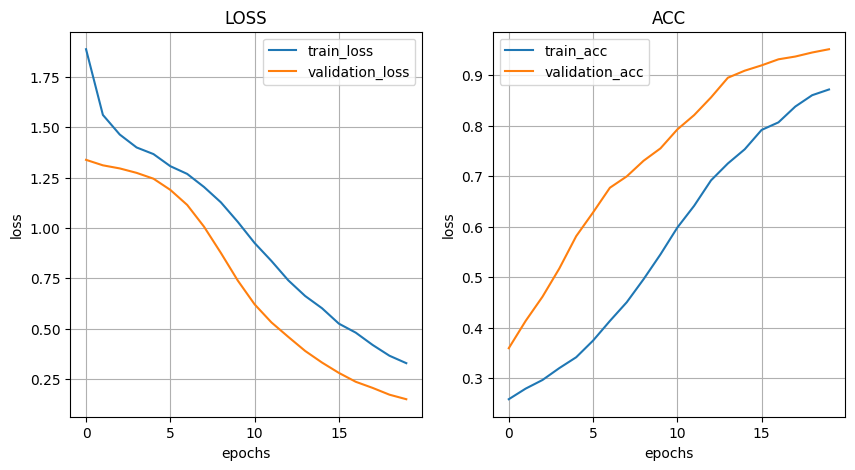

In [13]:
# include_top = False
# ResNet
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label="train_loss")
plt.plot(result.history["val_loss"], label="validation_loss")
plt.legend(loc="best")

plt.subplot(1,2,2)

plt.title("ACC")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["acc"], label="train_acc")
plt.plot(result.history["val_acc"], label="validation_acc")
plt.legend(loc="best")

model.evaluate(val_generator)